

---


# **Common process across all the types/models**


---


# Load Data & Visualize Data


---




In [1]:
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
#---------------------------------------------------------------------------------------------------------------------
mpl.rcParams['figure.figsize'] = (8, 6)
#mpl.rcParams['figure.figsize'] = (18, 16)
mpl.rcParams['axes.grid'] = False

#---------------------------------------------------------------------------------------------------------------------
#Loading the data
from google.colab import drive
drive.mount('/content/drive')

df_Merged_cleand = pd.read_csv("/content/drive/MyDrive/Project_TS_Walmart/Phase 2/Data/df_Merged_cleand.csv")
df_Merged_cleand.head(1)
#---------------------------------------------------------------------------------------------------------------------

# Features
#features_considered = ['store_nbr','item_nbr','station_nbr','tmax','depart','cool','snowfall','preciptotal','stnpressure','resultspeed','resultdir','avgspeed','Day','Month','Holiday','units']
features_considered = ['units','store_nbr','item_nbr','station_nbr','tmax','depart','cool','snowfall','preciptotal','stnpressure','resultspeed','resultdir','avgspeed','Day','Month']

features = df_Merged_cleand[features_considered].copy()
features.index = pd.to_datetime(df_Merged_cleand['date'], format='%Y.%m.%d')

#features["Holiday"].replace({"False": "0", "True": "1"}, inplace=True)
columns = ['units','store_nbr','item_nbr','station_nbr','tmax','depart','cool','snowfall','preciptotal','stnpressure','resultspeed','resultdir','avgspeed','Day','Month']

for clmn in columns:
  features[clmn] = pd.to_numeric(features[clmn], downcast="float")

features.head(1)

Mounted at /content/drive


,units,store_nbr,item_nbr,station_nbr,tmax,depart,cool,snowfall,preciptotal,stnpressure,resultspeed,resultdir,avgspeed,Day,Month
date,,,,,,,,,,,,,,,
2012-01-01,29.0,1.0,9.0,1.0,52.0,1.5,0.0,0.0,0.05,29.780001,3.6,20.0,4.6,1.0,1.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0e45f07d90>,
      dtype=object)

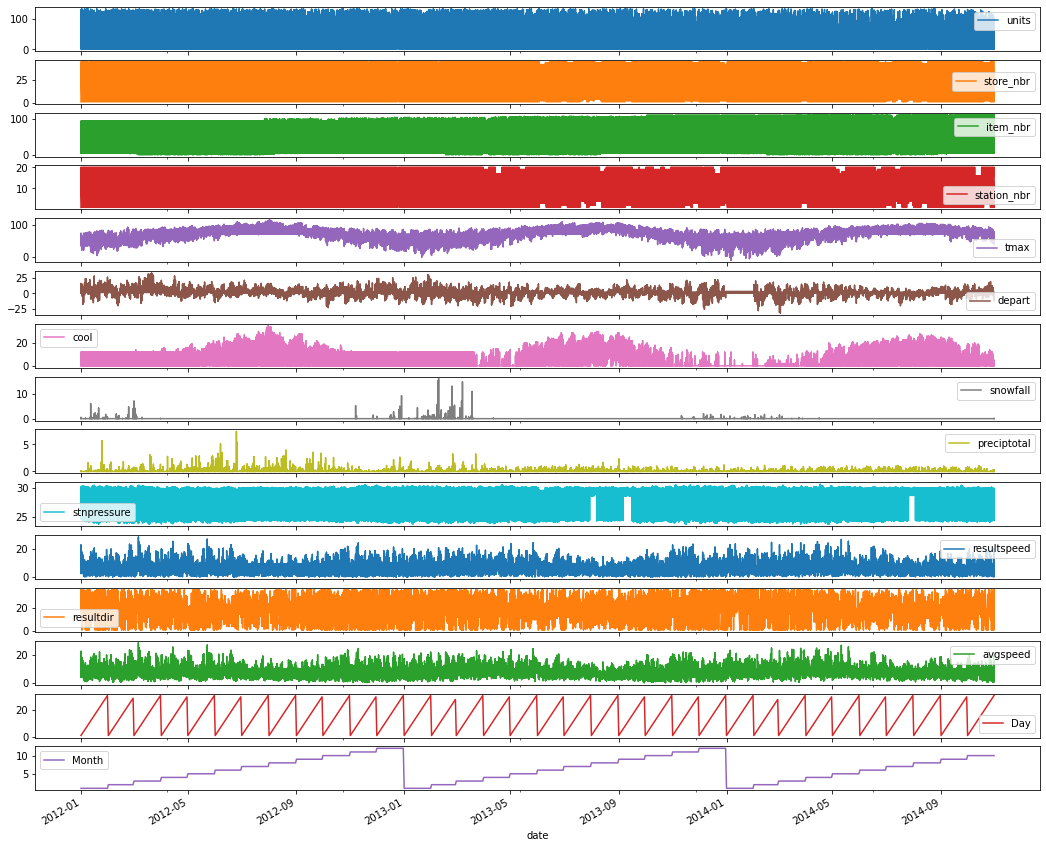

In [2]:
mpl.rcParams['figure.figsize'] = (18, 16)
features.plot(subplots=True)



---



---



# **TYPE 1**

---



---



# Train Validation Test Split

In [2]:
from tabulate import tabulate 
df_distribution = pd.DataFrame({'Total Rows':[features.shape[0]],'Train Top Index':[features.shape[0]*.75],'Validation Top Index':[features.shape[0]*.20],'Test Top Index':[features.shape[0]*.05]})
print(tabulate(df_distribution, headers = 'keys', tablefmt = 'psql'))

+----+--------------+-------------------+------------------------+------------------+
|    |   Total Rows |   Train Top Index |   Validation Top Index |   Test Top Index |
|----+--------------+-------------------+------------------------+------------------|
|  0 |       113709 |           85281.8 |                22741.8 |          5685.45 |
+----+--------------+-------------------+------------------------+------------------+


In [3]:
feature_target = pd.DataFrame({'units':features["units"]})
feature_target.index = features.index
#type(feature_target) #pandas.core.frame.DataFrame
df_features = features.copy()
df_features = df_features.drop('units', axis=1)

#((113679, 30, 15), (113679,))

In [4]:
def df_to_X_Y(df,df_target, window_size=30):
  df_as_np = df.to_numpy()
  df_target_as_np = df_target.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_target_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)
#----------------------------------------------------------------------
X, y = df_to_X_Y(df_features,feature_target)
X.shape, y.shape

((113679, 30, 14), (113679,))

In [5]:
X_train, y_train = X[:85281], y[:85281]
X_val, y_val = X[85281:108022], y[85281:108022]
X_test, y_test = X[108022:], y[108022:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((85281, 30, 14), (85281,), (22741, 30, 14), (22741,), (5657, 30, 14), (5657,))

In [ ]:
X_test[0]

**Standardization / Pre-processing**

In [7]:
temp_training_mean = np.mean(X_train[:, :, 0])
temp_training_std = np.std(X_train[:, :, 0])
                           
def preprocess(X):
  X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std
  return X

In [8]:
X_train = preprocess(X_train)
X_val   = preprocess(X_val)
X_test  = preprocess(X_test)

# LSTM Model 1

In [11]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
#--------------------------------------------------------------------------
model = Sequential()
model.add(InputLayer((30, 14)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                20224     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 20,753
Trainable params: 20,753
Non-trainable params: 0
_________________________________________________________________


In [12]:
cp = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, callbacks=[cp])

Epoch 1/30
2666/2666 [==============================] - ETA: 0s - loss: 1555.8528 - root_mean_squared_error: 39.4443

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


2666/2666 [==============================] - 21s 6ms/step - loss: 1555.8528 - root_mean_squared_error: 39.4443 - val_loss: 798.8632 - val_root_mean_squared_error: 28.2642
Epoch 2/30
2666/2666 [==============================] - 11s 4ms/step - loss: 1077.1832 - root_mean_squared_error: 32.8205 - val_loss: 804.2503 - val_root_mean_squared_error: 28.3593
Epoch 3/30
2666/2666 [==============================] - 11s 4ms/step - loss: 1073.4966 - root_mean_squared_error: 32.7643 - val_loss: 802.0287 - val_root_mean_squared_error: 28.3201
Epoch 4/30
2664/2666 [============================>.] - ETA: 0s - loss: 1070.1134 - root_mean_squared_error: 32.7126

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


2666/2666 [==============================] - 15s 5ms/step - loss: 1070.2070 - root_mean_squared_error: 32.7140 - val_loss: 793.8612 - val_root_mean_squared_error: 28.1755
Epoch 5/30
2663/2666 [============================>.] - ETA: 0s - loss: 1065.2396 - root_mean_squared_error: 32.6380

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


2666/2666 [==============================] - 15s 6ms/step - loss: 1065.4397 - root_mean_squared_error: 32.6411 - val_loss: 786.9448 - val_root_mean_squared_error: 28.0525
Epoch 6/30
2666/2666 [==============================] - 11s 4ms/step - loss: 1059.1814 - root_mean_squared_error: 32.5451 - val_loss: 792.1161 - val_root_mean_squared_error: 28.1446
Epoch 7/30
2665/2666 [============================>.] - ETA: 0s - loss: 1051.1489 - root_mean_squared_error: 32.4214

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


2666/2666 [==============================] - 14s 5ms/step - loss: 1051.1454 - root_mean_squared_error: 32.4214 - val_loss: 774.7695 - val_root_mean_squared_error: 27.8347
Epoch 8/30
2665/2666 [============================>.] - ETA: 0s - loss: 1041.9000 - root_mean_squared_error: 32.2785

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


2666/2666 [==============================] - 14s 5ms/step - loss: 1041.9154 - root_mean_squared_error: 32.2787 - val_loss: 765.5002 - val_root_mean_squared_error: 27.6677
Epoch 9/30
2666/2666 [==============================] - 11s 4ms/step - loss: 1032.8693 - root_mean_squared_error: 32.1383 - val_loss: 766.1642 - val_root_mean_squared_error: 27.6797
Epoch 10/30
2657/2666 [============================>.] - ETA: 0s - loss: 1021.9189 - root_mean_squared_error: 31.9675

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


2666/2666 [==============================] - 16s 6ms/step - loss: 1021.5235 - root_mean_squared_error: 31.9613 - val_loss: 759.5795 - val_root_mean_squared_error: 27.5605
Epoch 11/30
2663/2666 [============================>.] - ETA: 0s - loss: 1011.0578 - root_mean_squared_error: 31.7971

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


2666/2666 [==============================] - 14s 5ms/step - loss: 1011.0239 - root_mean_squared_error: 31.7966 - val_loss: 756.5934 - val_root_mean_squared_error: 27.5062
Epoch 12/30
2666/2666 [==============================] - 11s 4ms/step - loss: 999.9539 - root_mean_squared_error: 31.6220 - val_loss: 760.5154 - val_root_mean_squared_error: 27.5774
Epoch 13/30
2666/2666 [==============================] - 11s 4ms/step - loss: 990.7949 - root_mean_squared_error: 31.4769 - val_loss: 769.3492 - val_root_mean_squared_error: 27.7371
Epoch 14/30
2665/2666 [============================>.] - ETA: 0s - loss: 982.6993 - root_mean_squared_error: 31.3480

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


2666/2666 [==============================] - 15s 6ms/step - loss: 982.7009 - root_mean_squared_error: 31.3481 - val_loss: 754.2705 - val_root_mean_squared_error: 27.4640
Epoch 15/30
2659/2666 [============================>.] - ETA: 0s - loss: 974.4001 - root_mean_squared_error: 31.2154

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


2666/2666 [==============================] - 14s 5ms/step - loss: 974.2014 - root_mean_squared_error: 31.2122 - val_loss: 745.2720 - val_root_mean_squared_error: 27.2997
Epoch 16/30
2655/2666 [============================>.] - ETA: 0s - loss: 966.3673 - root_mean_squared_error: 31.0864

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


2666/2666 [==============================] - 14s 5ms/step - loss: 966.7205 - root_mean_squared_error: 31.0921 - val_loss: 739.6981 - val_root_mean_squared_error: 27.1974
Epoch 17/30
2661/2666 [============================>.] - ETA: 0s - loss: 958.6318 - root_mean_squared_error: 30.9618

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


2666/2666 [==============================] - 15s 5ms/step - loss: 958.6869 - root_mean_squared_error: 30.9627 - val_loss: 736.5724 - val_root_mean_squared_error: 27.1399
Epoch 18/30
2660/2666 [============================>.] - ETA: 0s - loss: 950.9483 - root_mean_squared_error: 30.8375

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


2666/2666 [==============================] - 15s 6ms/step - loss: 950.9475 - root_mean_squared_error: 30.8374 - val_loss: 733.3375 - val_root_mean_squared_error: 27.0802
Epoch 19/30
2666/2666 [==============================] - 11s 4ms/step - loss: 943.5161 - root_mean_squared_error: 30.7167 - val_loss: 736.6318 - val_root_mean_squared_error: 27.1410
Epoch 20/30
2666/2666 [==============================] - 11s 4ms/step - loss: 935.4219 - root_mean_squared_error: 30.5847 - val_loss: 738.5808 - val_root_mean_squared_error: 27.1768
Epoch 21/30
2654/2666 [============================>.] - ETA: 0s - loss: 928.4851 - root_mean_squared_error: 30.4711

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


2666/2666 [==============================] - 14s 5ms/step - loss: 928.5807 - root_mean_squared_error: 30.4726 - val_loss: 729.1890 - val_root_mean_squared_error: 27.0035
Epoch 22/30
2666/2666 [==============================] - 11s 4ms/step - loss: 920.6553 - root_mean_squared_error: 30.3423 - val_loss: 747.9047 - val_root_mean_squared_error: 27.3478
Epoch 23/30
2666/2666 [==============================] - 11s 4ms/step - loss: 913.8561 - root_mean_squared_error: 30.2301 - val_loss: 732.3978 - val_root_mean_squared_error: 27.0628
Epoch 24/30
2666/2666 [==============================] - 12s 5ms/step - loss: 907.3018 - root_mean_squared_error: 30.1215 - val_loss: 738.8694 - val_root_mean_squared_error: 27.1822
Epoch 25/30
2666/2666 [==============================] - 11s 4ms/step - loss: 900.7455 - root_mean_squared_error: 30.0124 - val_loss: 732.0279 - val_root_mean_squared_error: 27.0560
Epoch 26/30
2666/2666 [==============================] - 11s 4ms/step - loss: 893.9310 - root_mean_squ

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


2666/2666 [==============================] - 15s 6ms/step - loss: 887.6071 - root_mean_squared_error: 29.7927 - val_loss: 723.3915 - val_root_mean_squared_error: 26.8959
Epoch 28/30
2663/2666 [============================>.] - ETA: 0s - loss: 880.9938 - root_mean_squared_error: 29.6815

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


2666/2666 [==============================] - 15s 6ms/step - loss: 880.9612 - root_mean_squared_error: 29.6810 - val_loss: 709.8139 - val_root_mean_squared_error: 26.6423
Epoch 29/30
2666/2666 [==============================] - 11s 4ms/step - loss: 874.5652 - root_mean_squared_error: 29.5730 - val_loss: 723.3635 - val_root_mean_squared_error: 26.8954
Epoch 30/30
2666/2666 [==============================] - 11s 4ms/step - loss: 867.7957 - root_mean_squared_error: 29.4584 - val_loss: 717.9977 - val_root_mean_squared_error: 26.7955


In [13]:
from tensorflow.keras.models import load_model
model = load_model('model/')

In [14]:
train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results

,Train Predictions,Actuals
0,25.239920,1.0
1,26.361135,8.0
2,16.190975,2.0
3,32.776260,2.0
4,39.927711,64.0
...,...,...
85276,43.734146,44.0
85277,41.074928,3.0
85278,31.295033,1.0
85279,33.519966,50.0


(      Predictions  Actuals
 0       26.530098      3.0
 1       25.486113      5.0
 2       22.202028     28.0
 3       11.885750     11.0
 4       21.686186     46.0
 ...           ...      ...
 5652    19.274004     47.0
 5653    26.296795     39.0
 5654    15.310575      1.0
 5655    19.554491     10.0
 5656    16.677477      1.0
 
 [5657 rows x 2 columns], 651.96356)

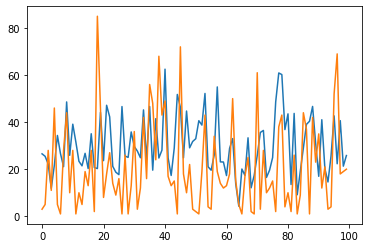

In [15]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(y, predictions)

plot_predictions(model, X_test, y_test)

# LSTM Model 2

In [17]:
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.LSTM(128,input_shape=(30,14),return_sequences=True))
model2.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model2.add(tf.keras.layers.LSTM(128,return_sequences=True))
model2.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model2.add(tf.keras.layers.Dropout(0.3))
model2.add(tf.keras.layers.LSTM(64,return_sequences=True))
model2.add(tf.keras.layers.Dropout(0.3))
model2.add(tf.keras.layers.Dense(1))
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 30, 128)           73216     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 30, 128)           0         
                                                                 
 lstm_6 (LSTM)               (None, 30, 128)           131584    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 30, 128)           0         
                                                                 
 dropout_2 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_7 (LSTM)               (None, 30, 64)            49408     
                                                                 
 dropout_3 (Dropout)         (None, 30, 64)           

In [19]:
cp = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, callbacks=[cp])

Epoch 1/30
2665/2666 [============================>.] - ETA: 0s - loss: 1099.2708 - root_mean_squared_error: 33.1553

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


2666/2666 [==============================] - 37s 12ms/step - loss: 1099.2666 - root_mean_squared_error: 33.1553 - val_loss: 799.5173 - val_root_mean_squared_error: 28.2784
Epoch 2/30
2666/2666 [==============================] - 23s 8ms/step - loss: 1084.3271 - root_mean_squared_error: 32.9293 - val_loss: 803.3569 - val_root_mean_squared_error: 28.3461
Epoch 3/30
2666/2666 [==============================] - 23s 9ms/step - loss: 1084.1913 - root_mean_squared_error: 32.9271 - val_loss: 802.9896 - val_root_mean_squared_error: 28.3396
Epoch 4/30
2666/2666 [==============================] - 23s 8ms/step - loss: 1084.1729 - root_mean_squared_error: 32.9269 - val_loss: 803.8994 - val_root_mean_squared_error: 28.3557
Epoch 5/30
2666/2666 [==============================] - 23s 9ms/step - loss: 1084.2006 - root_mean_squared_error: 32.9272 - val_loss: 802.8812 - val_root_mean_squared_error: 28.3377
Epoch 6/30
2666/2666 [==============================] - 23s 9ms/step - loss: 1084.1104 - root_mean_s

                     .



---



---


# **TYPE 2**

---



---



# Intial Setup

In [29]:
# Features
#features_considered = ['store_nbr','item_nbr','station_nbr','tmax','depart','cool','snowfall','preciptotal','stnpressure','resultspeed','resultdir','avgspeed','Day','Month','Holiday','units']
features_considered = ['store_nbr','item_nbr','station_nbr','tmax','depart','cool','snowfall','preciptotal','stnpressure','resultspeed','resultdir','avgspeed','Day','Month','units']

features = df_Merged_cleand[features_considered].copy()
features.index = pd.to_datetime(df_Merged_cleand['date'], format='%Y.%m.%d')
#-------------------------------------------------------------------------------------------------------------------------------------
#features["Holiday"].replace({"False": "0", "True": "1"}, inplace=True)
columns = ['store_nbr','item_nbr','station_nbr','tmax','depart','cool','snowfall','preciptotal','stnpressure','resultspeed','resultdir','avgspeed','Day','Month','units']

for clmn in columns:
  features[clmn] = pd.to_numeric(features[clmn], downcast="float")

#-------------------------------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------------------
BATCH_SIZE = 10 # bacth size in batch-SGD/variants
BUFFER_SIZE = 10000 # for shuffling the dataset

# Train and evaluate
STEPS_PER_EPOCH = 200
EPOCHS = 30
#-------------------------------------------------------------------------------------------------------------------------------------

# Train-Test Split

In [30]:
TRAIN_SPLIT = 90000
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

# Multivariate Data Generator for LSTM Model

In [31]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step) # step used here.
    data.append(dataset[indices])

    if single_step: # single_step used here.
      labels.append(target[i+target_size]) 
    else:
      labels.append(target[i:i+target_size]) 

  return np.array(data), np.array(labels)



# Generate data
past_history = 120 # Days
future_target = 0 # Immediate
STEP = 1 # one obs => 1 Day

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

print(x_train_single.shape)
print(y_train_single.shape)

(89880, 120, 15)
(89880,)


In [32]:
#TF dataset

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

print(train_data_single)
print(val_data_single)

<RepeatDataset element_spec=(TensorSpec(shape=(None, 120, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>
<RepeatDataset element_spec=(TensorSpec(shape=(None, 120, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


# Model 3 - Setup

In [33]:
# Model
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=STEPS_PER_EPOCH,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/30
200/200 [==============================] - 3s 8ms/step - loss: 31.2269 - val_loss: 28.4123
Epoch 2/30
200/200 [==============================] - 1s 6ms/step - loss: 27.9848 - val_loss: 26.8538
Epoch 3/30
200/200 [==============================] - 1s 6ms/step - loss: 25.9849 - val_loss: 25.7634
Epoch 4/30
200/200 [==============================] - 1s 6ms/step - loss: 26.2452 - val_loss: 24.9842
Epoch 5/30
200/200 [==============================] - 1s 6ms/step - loss: 26.3605 - val_loss: 24.3607
Epoch 6/30
200/200 [==============================] - 1s 6ms/step - loss: 25.5781 - val_loss: 23.8929
Epoch 7/30
200/200 [==============================] - 1s 6ms/step - loss: 25.0557 - val_loss: 23.5231
Epoch 8/30
200/200 [==============================] - 1s 6ms/step - loss: 24.9416 - val_loss: 23.1909
Epoch 9/30
200/200 [==============================] - 1s 6ms/step - loss: 24.3070 - val_loss: 22.8505
Epoch 10/30
200/200 [==============================] - 1s 6ms/step - loss: 24.4078

# Visualization

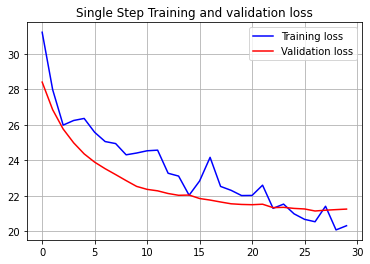

In [34]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()
  plt.grid()

  plt.show()



plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

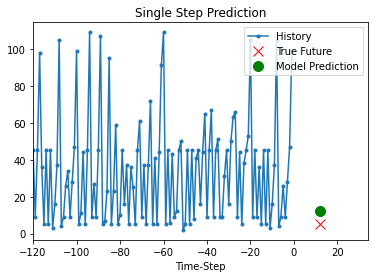

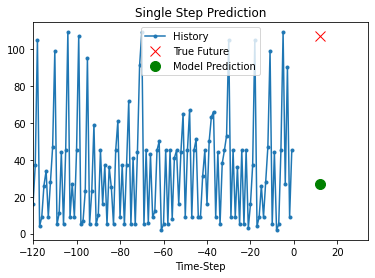

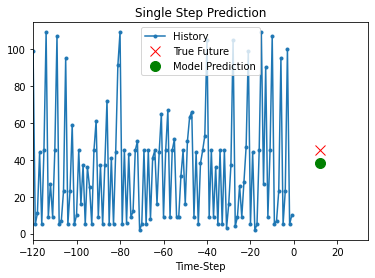

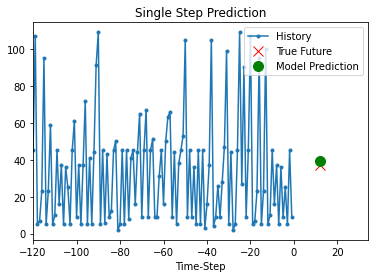

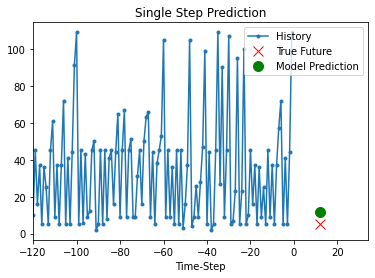

In [35]:
#utility function
def create_time_steps(length):
  return list(range(-length, 0))
  
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go'] # dot-line, red-x, green-o  refer: https://matplotlib.org/3.1.1/api/markers_api.html
  time_steps = create_time_steps(plot_data[0].shape[0])
  
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

# plot time series and predicted values

for x, y in val_data_single.take(5):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()